# *Challenge 1*: A **kernel** methods / **DL** pipeline for the FashionMNIST dataset

Advanced Topics in Machine Learning -- Fall 2024, UniTS

<a target="_blank" href="https://colab.research.google.com/github/ganselmif/adv-ml-units/blob/main/notebooks/AdvML_Challenge_1.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>


During this first *challenge* of the *Advanced Machine Learning Course*, you will experiment with the development of a data analysis pipeline based upon various techniques seen during the lectures so far: some **unsupervised** (*e.g.* *PCA*, *kernel-PCA*) and some others **supervised** (*e.g.* *kernel SVM* and *Artificial Neural Networks* for classification).

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### The dataset

The dataset of interest for the *challenge* will be [*FashionMNIST*](https://github.com/zalandoresearch/fashion-mnist), an *MNIST*-like dataset of grayscale images of fashion items. Originally developed by Zalando Research in 2017 as a harder (yet *drop-in* compatible) replacement for the original *MNIST* dataset, it has been used in several papers and competitions since then.

Remember to consider the *dataset* mentioned below as the **training set** offered by *FashionMNIST*. Use the *test set* only at the end, to evaluate the overall accuracy of the pipeline!

In [2]:
!pip install scikit-dimension

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.4/66.4 kB 2.3 MB/s eta 0:00:00


In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset, Subset, Dataset
from torchvision import datasets, transforms
import random
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import numpy as np
from numpy import exp
from scipy import linalg as LA
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import KernelPCA
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics import silhouette_score
from scipy.stats import mode
from sklearn.metrics import pairwise_distances_argmin_min, accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import plotly.graph_objects as go
from sklearn.mixture import BayesianGaussianMixture
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from skdim.id import TwoNN
from matplotlib.colors import ListedColormap
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
import itertools

output_dir = '/Users/emanuele/Desktop/TRIESTE/adv_deep/report_chal1/plots/'
#output_dir = '/content/drive/MyDrive/'

In [ ]:
# Set a fixed seed for reproducibility
torch.manual_seed(34)
np.random.seed(34)


# Define the transform to apply to the data
transform = transforms.Compose([
    transforms.ToTensor(), # Convert the data to a PyTorch tensor
    transforms.Lambda(lambda x: x.view(-1)),
])

# Download and load the training data
train_dataset = datasets.FashionMNIST(
    root='./data', # Path to store the data
    train=True, # Load the training data
    download=True, # Download the data if it doesn't exist
    transform=transform # Apply the transform
)
train_loader = DataLoader(train_dataset, batch_size=6000, shuffle=True)

# Download and load the test data
test_dataset = datasets.FashionMNIST(
    root='./data', # Path to store the data
    train=True, # Load the test data
    download=True, # Download the data if it doesn't exist
    transform=transform # Apply the transform
)
test_loader = DataLoader(test_dataset, batch_size=2000, shuffle=True)

images, labels = next(iter(train_loader))  # Take a batch of images and labels

# Convert the PyTorch tensor to a NumPy array
images_np = images.numpy()
labels_np = labels.numpy()

test_images, test_labels = next(iter(test_loader))  # Take a batch of images and labels

# Convert the PyTorch tensor to a NumPy array
test_images_np = test_images.numpy()
test_labels_np = test_labels.numpy()

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.4MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.76MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 22.4MB/s]


Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



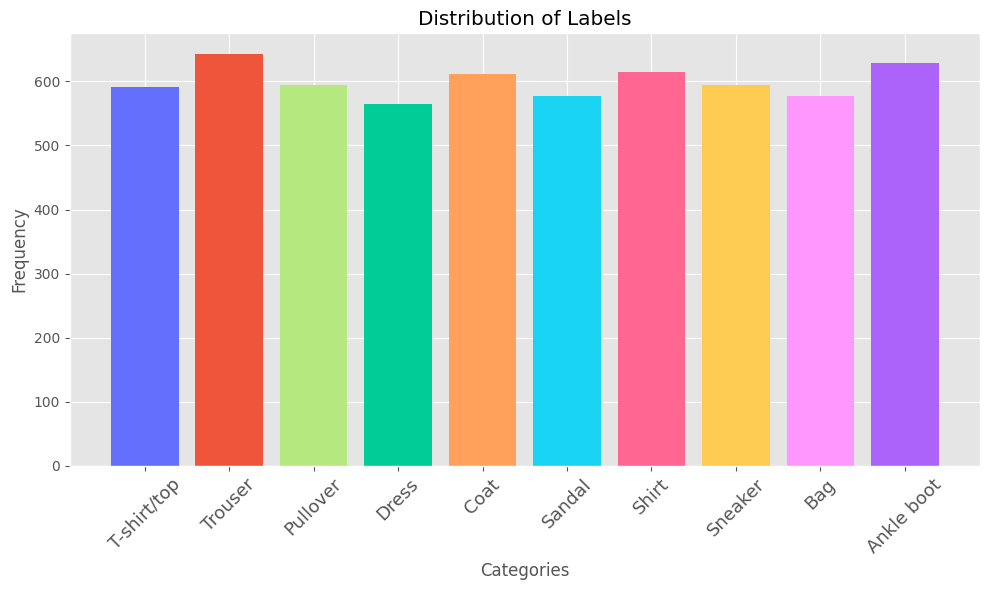

In [ ]:
# Count the occurrences of each label
label_counts = np.bincount(labels_np)

categories = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

category_colors = [
    "#636EFA", "#EF553B", "#B6E880", "#00CC96", "#FFA15A",
    "#19D3F3", "#FF6692", "#FECB52", "#FF97FF", "#AB63FA",
]

plt.style.use('ggplot')

# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, label_counts, color=category_colors)

plt.xlabel("Categories")
plt.ylabel("Frequency")
plt.title("Distribution of Labels")

plt.xticks(rotation=45, size=13)

plt.tight_layout()

plt.savefig(f'{output_dir}distribution.png')
plt.show()




### Section 1: Understanding data geometry

Load the dataset in the most suitable form for the tasks that follow. Then, perform the following steps, with the goal of developing a geometric understanding of the dataset:

1. Perform a (linear) *PCA* on the dataset, and plot the first two (or three!) principal components along with the true label. Comment on data separation.

2. Perform a *kernel-PCA* on the dataset with a Gaussian kernel, and plot the first two (or three!) principal components along with the true label. Try to tune the dispersion parameter of the kernel to obtain a good separation of the data. Comment.

3. Perform another *kernel-PCA* on the dataset with another kernel of your own choice, and plot the first two (or three!) principal components along with the true label. Try to tune the degree of the polynomial kernel to obtain a good separation of the data. Comment.

Whenever suitable, try to complement your analysis with some graphs!

**IMPORTANT NOTICE**: As some of you have reported, performing *kernel PCA* on the entire *FashionMNIST* dataset can be memory- and time- demanding (as it scales with the square of the number of datapoints!). In case you want to reduce such requirements, you can either:
  - Reduce the number of datapoints on which to perform *kPCA*, *e.g.* by slicing the randomly-shuffled dataset *(most effective!)*;
  - Reduce the size of the images in the dataset (*i.e.* by dropping even/odd rows/columns, or performing local pooling) *(somehow effective: you may want to try it if you do not have access to powerful compute, but still enjoy challenges!)*.

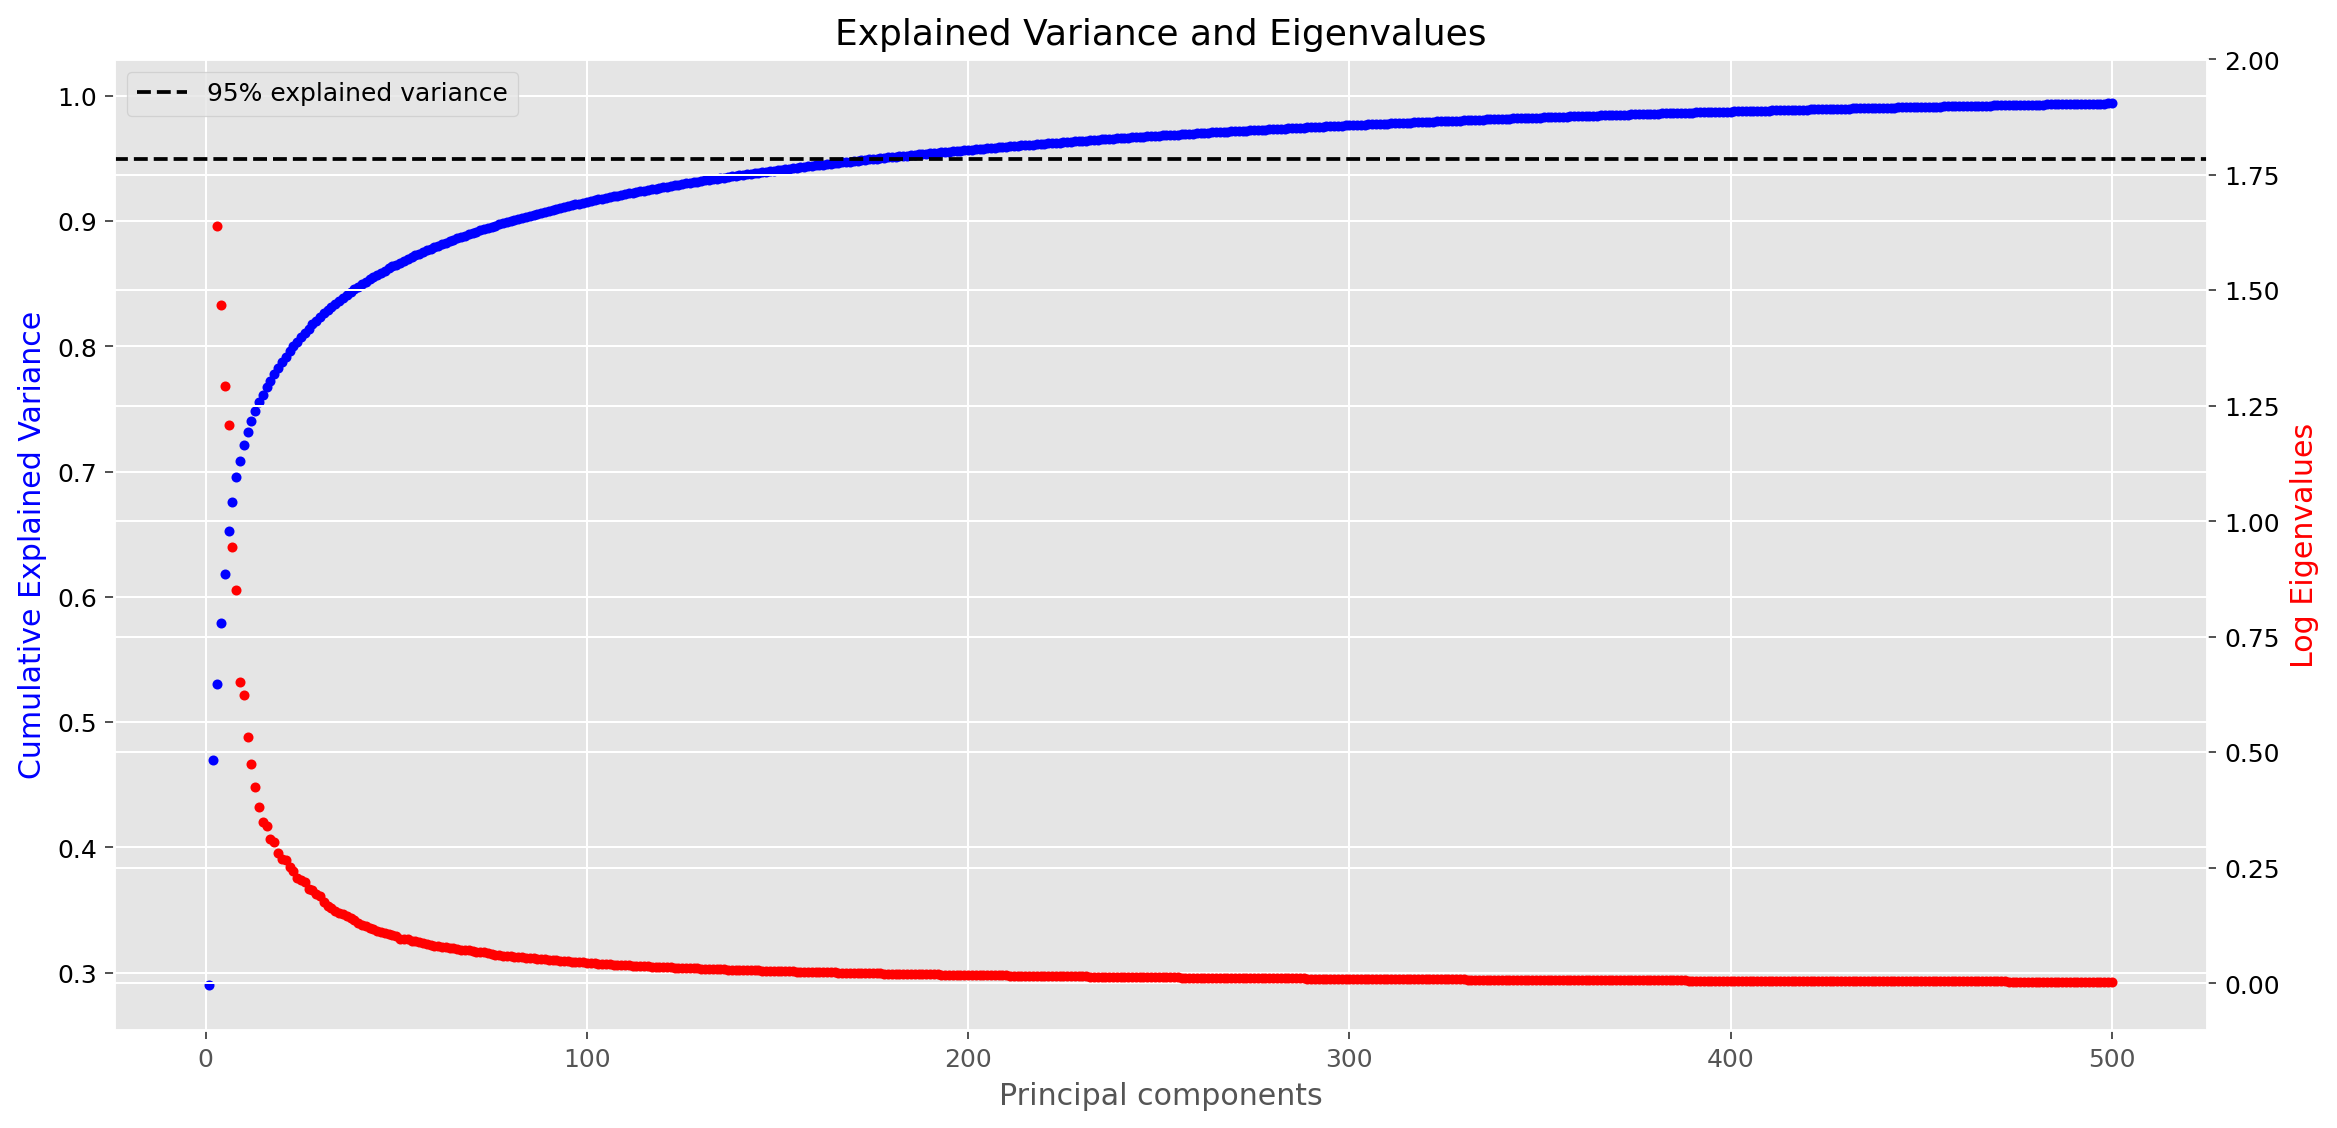

In [ ]:
# PCA
pca = PCA()
pca.fit(images_np)

# Explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Eigenvalues
eigenvalues = pca.explained_variance_

fig, ax1 = plt.subplots(figsize=(15, 7), dpi=180)

# Plot
ax1.plot(range(1, 501), cumulative_variance[0:500], marker='o', markersize=3, linestyle='', color='b')
ax1.set_xlabel('Principal components')
ax1.set_ylabel('Cumulative Explained Variance', color='b')
ax1.axhline(y=0.95, color='k', linestyle='--', label='95% explained variance')
ax1.tick_params(axis='y', labelcolor='k')

ax2 = ax1.twinx()
ax2.plot(range(1, 501), np.log(eigenvalues[0:500] + 1), marker='o', markersize=3, linestyle='', label='Eigenvalues (log)', color='r')
ax2.set_ylabel('Log Eigenvalues', color='r')
ax2.set_ylim(-0.1, 2)
ax2.tick_params(axis='y', labelcolor='k')


ax1.legend(loc='upper left')

plt.grid(True)


plt.title('Explained Variance and Eigenvalues')

plt.savefig(f'{output_dir}expvar.png')

plt.show()

In [7]:
for i in range(0,151,15):
  if i == 0:
    print(f"Principal components {i+1}, explained variance: {cumulative_variance[i]:.2f}")
  else:
    print(f"Principal components {i}, explained variance: {cumulative_variance[i-1]:.2f}")

Principal components 1, explained variance: 0.29
Principal components 15, explained variance: 0.76
Principal components 30, explained variance: 0.82
Principal components 45, explained variance: 0.86
Principal components 60, explained variance: 0.88
Principal components 75, explained variance: 0.90
Principal components 90, explained variance: 0.91
Principal components 105, explained variance: 0.92
Principal components 120, explained variance: 0.93
Principal components 135, explained variance: 0.93
Principal components 150, explained variance: 0.94


In [8]:
estimator = TwoNN()
intrinsic_dim = estimator.fit(images_np).dimension_
print(f"Estimated intrinsic dimension: {intrinsic_dim:.0f}" )

Estimated intrinsic dimension: 15


In [9]:
"""LINEAR PCA 2D"""
LIN2D_pca = KernelPCA(n_components=2, kernel='linear')
lin2d = LIN2D_pca.fit_transform(images_np)
"""RBF PCA 2D"""
RBF2D_pca = KernelPCA(n_components=2, kernel='rbf', gamma=0.01)  # Adjust gamma as needed
rbf2d = RBF2D_pca.fit_transform(images_np)
"""COSINE PCA 2D"""
COS2D_pca = KernelPCA(n_components=2, kernel='cosine')
cos2d = COS2D_pca.fit_transform(images_np)


"""LINEAR PCA 3D"""
LIN3D_pca = PCA(n_components=3)
lin3d = LIN3D_pca.fit_transform(images_np)
"""RBF PCA 3D"""
RBF3D_pca = KernelPCA(n_components=3, kernel='rbf', gamma=0.01)  # Adjust gamma as needed
rbf3d = RBF3D_pca.fit_transform(images_np)
"""LINEAR PCA 3D"""
COS3D_pca = KernelPCA(n_components=3, kernel='cosine')
cos3d = COS3D_pca.fit_transform(images_np)


In [10]:
colmap = ListedColormap(category_colors)

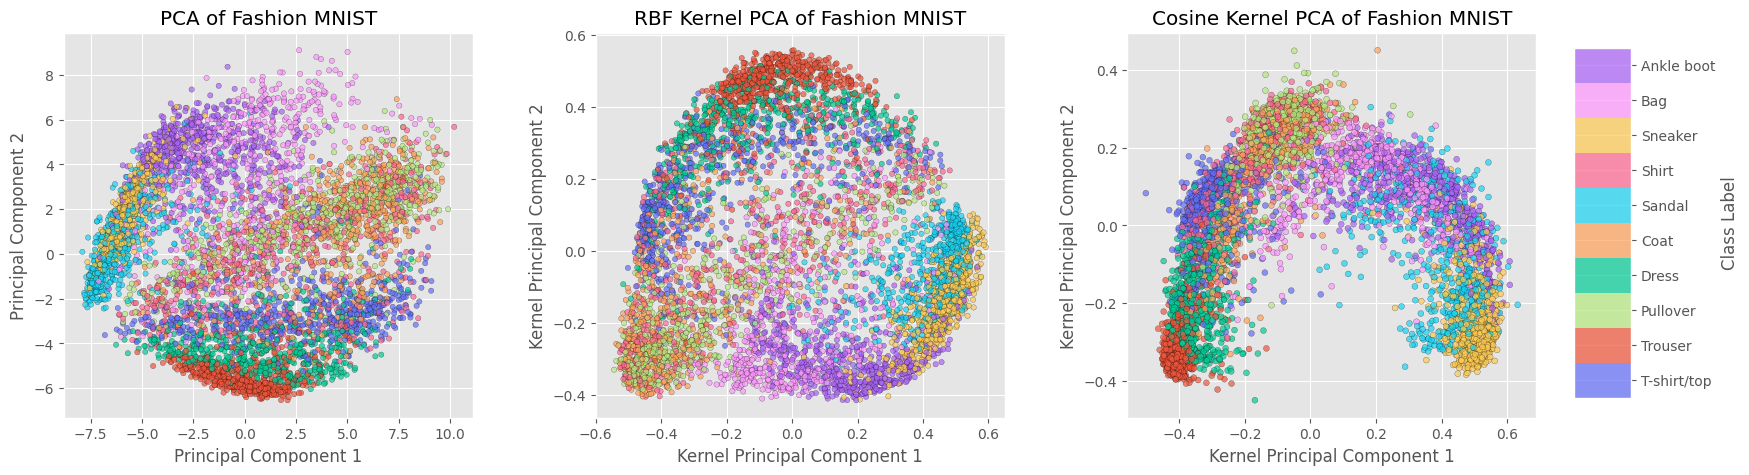

In [ ]:
fig = plt.figure(figsize=(19, 5))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1], wspace=0.3)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

# PCA Linear scatter plot
scatter1 = ax1.scatter(lin2d[:, 0], lin2d[:, 1], c=labels_np, cmap=colmap,
                       alpha=0.7, s=15, edgecolors='k', linewidth=.2)
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_title('Linear Kernel PCA of Fashion MNIST')
ax1.grid(True)

# RBF Kernel PCA scatter plot
scatter2 = ax2.scatter(rbf2d[:, 0], rbf2d[:, 1], c=labels_np, cmap=colmap,
                       alpha=0.7, s=15, edgecolors='black', linewidths=0.2)
ax2.set_xlabel('Kernel Principal Component 1')
ax2.set_ylabel('Kernel Principal Component 2')
ax2.set_title('RBF Kernel PCA of Fashion MNIST')
ax2.grid(True)

# Cosine Kernel PCA scatter plot
scatter3 = ax3.scatter(cos2d[:, 0], cos2d[:, 1], c=labels_np, cmap=colmap,
                       alpha=0.7, s=18, edgecolors='k', linewidths=0.2)
ax3.set_xlabel('Kernel Principal Component 1')
ax3.set_ylabel('Kernel Principal Component 2')
ax3.set_title('Cosine Kernel PCA of Fashion MNIST')
ax3.grid(True)

cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # [x, y, width, height]
cbar = fig.colorbar(scatter3, cax=cbar_ax, boundaries=np.arange(-0.5, 10, 1))
cbar.set_ticks(np.arange(10))  # Tick at each class center
cbar.set_ticklabels(categories)  # Labels corresponding to class numbers
cbar.set_label('Class Label')

plt.tight_layout()

plt.savefig(f'{output_dir}pca2d.png')

plt.show()


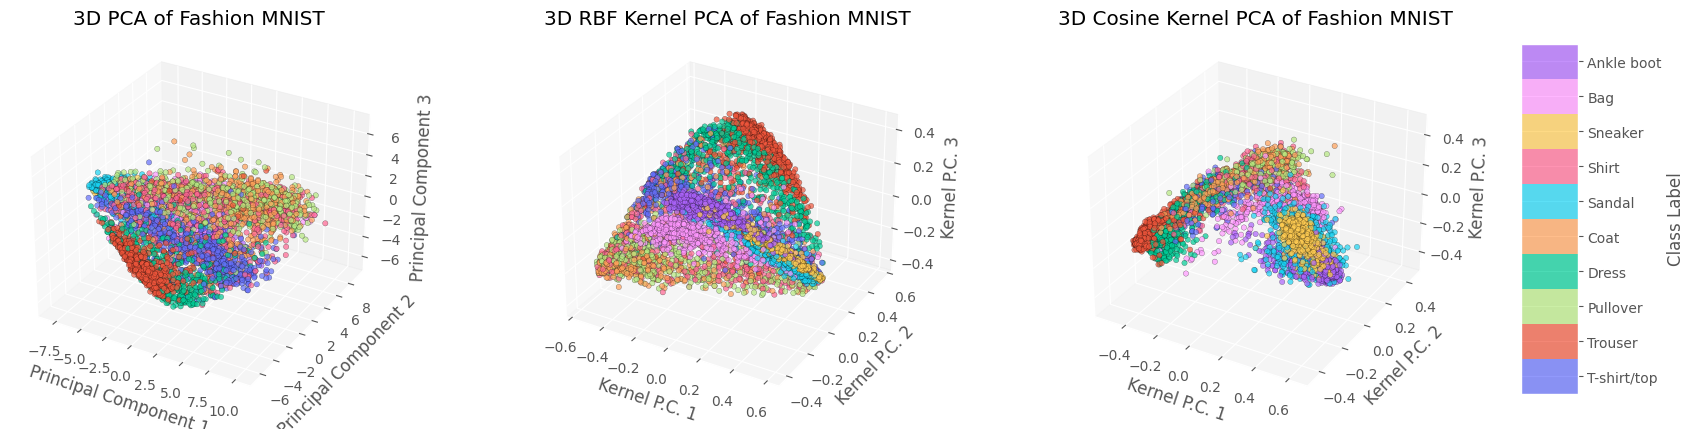

In [ ]:
fig = plt.figure(figsize=(19, 5))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1], wspace=0.4)  # Increase wspace slightly

ax1 = fig.add_subplot(gs[0], projection='3d')
ax2 = fig.add_subplot(gs[1], projection='3d')
ax3 = fig.add_subplot(gs[2], projection='3d')

ax1.set_facecolor('white')
ax2.set_facecolor('white')
ax3.set_facecolor('white')

# 3D PCA Linear scatter plot
scatter1 = ax1.scatter(lin3d[:, 0], lin3d[:, 1], lin3d[:, 2], c=labels_np, cmap=colmap,
                       alpha=0.7, s=15, edgecolors='black', linewidths=0.2)
ax1.set_xlabel('Principal Component 1')
ax1.set_ylabel('Principal Component 2')
ax1.set_zlabel('Principal Component 3')
ax1.set_title('3D Linear Kernel PCA of Fashion MNIST')
ax1.grid(True)

# 3D RBF Kernel PCA scatter plot
scatter2 = ax2.scatter(rbf3d[:, 0], rbf3d[:, 1], rbf3d[:, 2], c=labels_np, cmap=colmap,
                       alpha=0.7, s=15, edgecolors='black', linewidths=0.2)
ax2.set_xlabel('Kernel P.C. 1')
ax2.set_ylabel('Kernel P.C. 2')
ax2.set_zlabel('Kernel P.C. 3')
ax2.set_title('3D RBF Kernel PCA of Fashion MNIST')
ax2.grid(True)

# 3D Cosine Kernel PCA scatter plot
scatter3 = ax3.scatter(cos3d[:, 0], cos3d[:, 1], cos3d[:, 2], c=labels_np, cmap=colmap,
                       alpha=0.7, s=15, edgecolors='black', linewidths=0.2)
ax3.set_xlabel('Kernel P.C. 1')
ax3.set_ylabel('Kernel P.C. 2')
ax3.set_zlabel('Kernel P.C. 3')
ax3.set_title('3D Cosine Kernel PCA of Fashion MNIST')
ax3.grid(True)

cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.7])  # [x, y, width, height]
cbar = fig.colorbar(scatter3, cax=cbar_ax, boundaries=np.arange(-0.5, 10, 1))
cbar.set_ticks(np.arange(10))  # Tick at each class center
cbar.set_ticklabels(categories)  # Labels corresponding to class numbers
cbar.set_label('Class Label')

plt.subplots_adjust(right=0.88)  
plt.savefig(f'{output_dir}pca3d.png')
plt.show()




### Section 2: Bridging *unsupervised* and *supervised*

Choose one of the results obtained in the previous section (you should choose the one better explaining data geometry), and ignore the true labels. Then, perform the following steps:

1. Considering only the first $10$ components of the *(kernel-)PCA* and try to assign $10$ labels to the resulting datapoints. Choose the approach you deem most suitable. Comment on the results, by considering:
    
    a. How well does the label-assignment just performed reflect the true labels?

    b. Does the number of components used ($10$) reflect the actual *knee-* or *gap-* *point* of the spectrum associated to the principal components?

Whenever suitable, try to complement your analysis with some graphs!

In [13]:
kernel_pca = KernelPCA(n_components=10, kernel='rbf', gamma=0.01)
kpca_result_np = kernel_pca.fit_transform(images_np)

In [ ]:
labels_original = labels_np  

# Dirichlet Process Gaussian Mixture Model
dpgmm = BayesianGaussianMixture(
    n_components=10,  # Limite massimo di cluster
    covariance_type='full',
    weight_concentration_prior_type='dirichlet_process',
    random_state=30
)

# Fitting 
clusters = dpgmm.fit_predict(kpca_result_np)

# Source (categories) e target (clusters)
source = []  # Indici delle categorie di partenza
target = []  # Indici dei cluster di destinazione
values = []  # Frequenza dei flussi
colors = []  # Colori dei flussi


# Number of points for each combination category-cluster
for cat_idx, category in enumerate(categories):
    for cluster_idx in range(dpgmm.n_components):
        count = np.sum((labels_original == cat_idx) & (clusters == cluster_idx))
        if count > 0:
            source.append(cat_idx)
            target.append(cluster_idx + len(categories))  # Shift per i cluster
            values.append(count)
            colors.append(category_colors[cat_idx])  # Colore del flusso basato sulla categoria

used_clusters = list(set(target))
lab = categories + [f"Cluster {i - len(categories)}" for i in used_clusters]

target = [lab.index(f"Cluster {i - len(categories)}") for i in target]

# Sankey map
fig = go.Figure(data=[go.Sankey(
    node=dict(
        pad=15,  
        thickness=20, 
        line=dict(color="black", width=0.5),
        label=lab,
        color= category_colors + ["#ffffff"] * len(used_clusters)
    ),
    link=dict(
        source=source,
        target=target,
        value=values,
        color=colors 
    )
)])

fig.update_layout(title_text="Mappa di Sankey: FashionMNIST e Clustering (DPGMM)", font_size=10)
fig.show()


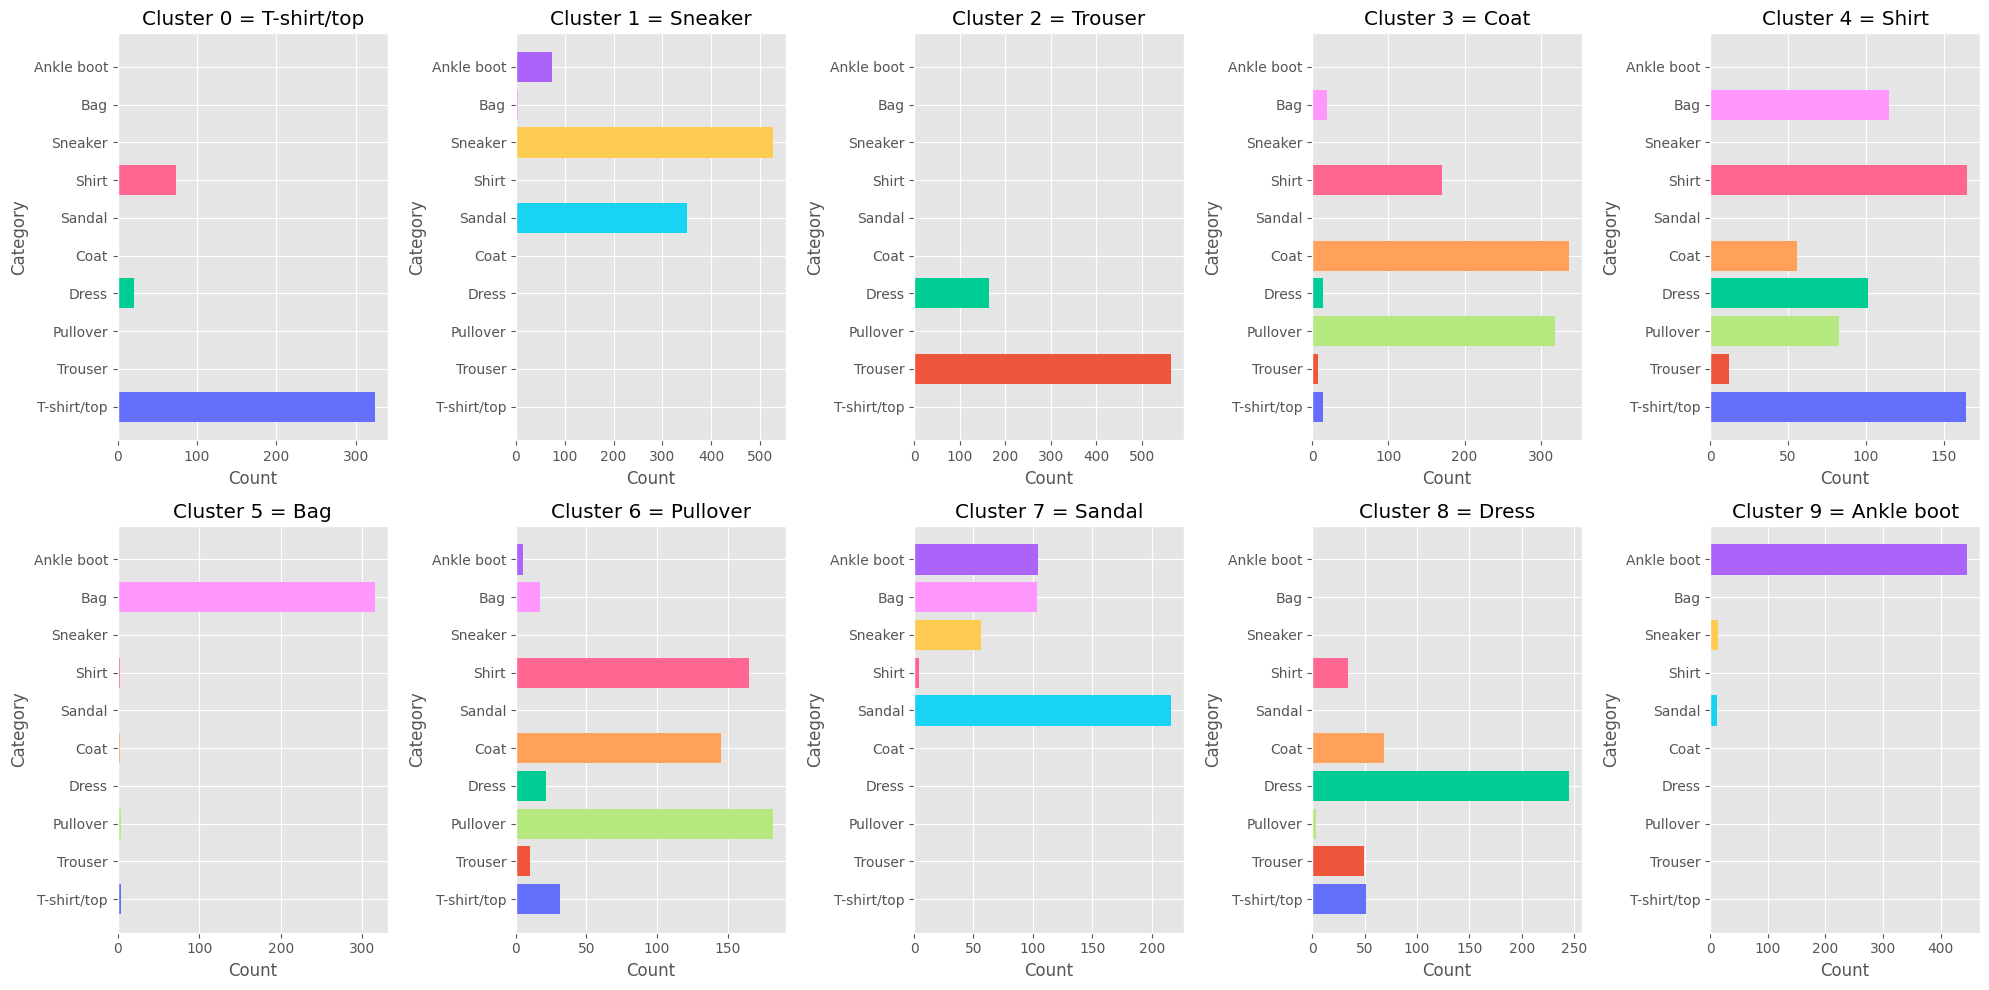

In [ ]:
n_clusters = len(np.unique(clusters))
category_counts = []

for cluster_idx in range(n_clusters):
    counts = [np.sum((labels_original == cat_idx) & (clusters == cluster_idx)) for cat_idx in range(len(categories))]
    category_counts.append(counts)

fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()

for cluster_idx, ax in enumerate(axes[:n_clusters]):
    ax.barh(categories, category_counts[cluster_idx], color=category_colors[:len(categories)]) 
    most_comm_lab = categories[np.argmax(category_counts[cluster_idx])]
    ax.set_title(f"Cluster {cluster_idx} = {most_comm_lab}")
    ax.set_xlabel("Count")
    ax.set_ylabel("Category")

for ax in axes[n_clusters:]:
    ax.axis("off")

plt.tight_layout()
plt.show()


### Section 3: (Supervised) classification

Consider the dataset composed of the original images, with the label assigned in the previous section (regardless of its actual match with the true label!). Then, define and learn a classifier that can predict the label of a new image. Specifically:

1. Learn a *kernel-SVM* on the data/label pairs. The choice of the kernel and its hyperparameters is up to your experimentation and time availability. Comment on your choices and results.

2. Learn a *fully-connected NN* on the data/label pairs. The choice of the architecture and its hyperparameters is up to your experimentation and time availability: show at least two different hyperparameter configurations, and comment on the results.

3. Learn a *CNN* on the data/label pairs. The choice of the architecture and its hyperparameters is up to your experimentation and time availability. Comment on the results with special respect to the FCN architecture.

In [ ]:
# Hyperparameter grid
param_grid = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10]},  # For linear kernel
    {'kernel': ['rbf'], 'C': [0.1, 1, 10], 'gamma': [0.01, 0.1, 1]},  # For RBF kernel
]

# 5-fold cross-validation setup
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform grid search
svm = SVC(random_state=34)
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=kf, scoring='accuracy', n_jobs=-1)
grid_search.fit(images_np, clusters)

# Best parameters and accuracy
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print(f"Best Parameters: {best_params}")
print(f"Best 3-Fold CV Accuracy: {best_accuracy:.4f}")

Best Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
Best 5-Fold CV Accuracy: 0.9418


In [19]:
X = images
y = clusters

In [ ]:
# Define the NeuralNetwork class
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, act, output_size):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.act = act
        self.fc3 = nn.Linear(hidden_size, output_size)

        # Initialize weights with N(0, 1)
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=1)
                nn.init.zeros_(m.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc3(x)
        return x

# Define the CNN class with flexible architecture
class CNN(nn.Module):
    def __init__(self, conv1_out_channels, conv2_out_channels, fc1_neurons, act, output_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, conv1_out_channels, kernel_size=3, stride=1, padding=1)
        self.act = act
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv2d(conv1_out_channels, conv2_out_channels, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(conv2_out_channels * 7 * 7, fc1_neurons)
        self.fc2 = nn.Linear(fc1_neurons, output_size)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.act(x)
        x = self.pool(x)
        x = x.view(-1, x.size(1) * 7 * 7)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        return x

In [ ]:

# Check for CUDA availability
if torch.backends.mps.is_available():
    device = torch.device('mps')  
elif torch.cuda.is_available():
    device = torch.device('cuda')  
else:
    device = torch.device('cpu') 

print(f"Using device: {device}")


Using device: cuda


In [22]:
# Convert data to PyTorch tensors
X_tensor = X.to(device)
y_tensor = torch.tensor(y, dtype=torch.long).to(device)

# Create a dataset
dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)

In [ ]:

# Hyperparameter grid
hidden_sizes = [128, 256, 512]
learning_rates = [0.01, 0.001]
batch_sizes = [32, 64, 128]
activation_functions = [nn.ReLU(), nn.Tanh()]
epochs = 20
k_folds = 3

# Define input and output sizes
input_size = X.shape[1]
output_size = 10

# Grid search setup
best_nn_model = None
best_params = None
best_accuracy = 0

# Perform grid search with 3-fold CV
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
for hidden_size, lr, batch_size, act in itertools.product(hidden_sizes, learning_rates, batch_sizes, activation_functions):
    print(f"Evaluating hidden_size={hidden_size}, lr={lr}, batch_size={batch_size}, activation={act}")

    fold_accuracies = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(dataset)):
        print(f"Fold {fold + 1}/{k_folds}")

        # Create DataLoaders for the current fold
        train_subset = Subset(dataset, train_idx)
        test_subset = Subset(dataset, test_idx)
        train_loader_fold = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        test_loader_fold = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

        # Initialize the model, criterion, and optimizer
        model = NeuralNetwork(input_size, hidden_size, act, output_size).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Training loop
        for epoch in range(epochs):
            model.train()
            for inputs, lab in train_loader_fold:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, lab)
                loss.backward()
                optimizer.step()

        # Evaluate the model on the test set
        model.eval()
        all_predictions = []
        all_labels = []
        with torch.no_grad():
            for inputs, lab in test_loader_fold:
                outputs = model(inputs)
                _, predictions = torch.max(outputs, 1)
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(lab.cpu().numpy())

        # Compute accuracy for the current fold
        accuracy = accuracy_score(all_labels, all_predictions)
        fold_accuracies.append(accuracy)
        print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")

    # Compute mean accuracy across folds
    mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Mean Accuracy for hidden_size={hidden_size}, lr={lr}, batch_size={batch_size}, activation={act}: {mean_accuracy:.4f}")
    print("------------------------------------")

    # Save the best model
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_params = (hidden_size, lr, batch_size, act)
        best_nn_model = model

print(f"Best parameters: hidden_size={best_params[0]}, lr={best_params[1]}, batch_size={best_params[2]}, activation={best_params[3]}")
print(f"Best mean accuracy: {best_accuracy:.4f}")

torch.save(best_nn_model.state_dict(), f'{output_dir}../fcnn_model_best.pth')

hidden_size, lr_nn, batch_size_nn, act_nn = best_params




Evaluating hidden_size=128, lr=0.01, batch_size=32, activation=ReLU()
Fold 1/3
Fold 1 Accuracy: 0.8690
Fold 2/3
Fold 2 Accuracy: 0.8325
Fold 3/3
Fold 3 Accuracy: 0.8420
Mean Accuracy for hidden_size=128, lr=0.01, batch_size=32, activation=ReLU(): 0.8478
------------------------------------
Evaluating hidden_size=128, lr=0.01, batch_size=32, activation=Tanh()
Fold 1/3
Fold 1 Accuracy: 0.7975
Fold 2/3
Fold 2 Accuracy: 0.7835
Fold 3/3
Fold 3 Accuracy: 0.8105
Mean Accuracy for hidden_size=128, lr=0.01, batch_size=32, activation=Tanh(): 0.7972
------------------------------------
Evaluating hidden_size=128, lr=0.01, batch_size=64, activation=ReLU()
Fold 1/3
Fold 1 Accuracy: 0.8530
Fold 2/3
Fold 2 Accuracy: 0.8255
Fold 3/3
Fold 3 Accuracy: 0.8280
Mean Accuracy for hidden_size=128, lr=0.01, batch_size=64, activation=ReLU(): 0.8355
------------------------------------
Evaluating hidden_size=128, lr=0.01, batch_size=64, activation=Tanh()
Fold 1/3
Fold 1 Accuracy: 0.8175
Fold 2/3
Fold 2 Accuracy

In [25]:
# Reshape X_tensor to match the input dimensions for CNN
X_tensor_cnn = X_tensor.view(-1, 1, 28, 28).to(device)  # Assuming input size is 28x28
y_tensor_cnn = y_tensor.to(device)

# Create a dataset for CNN
dataset_cnn = torch.utils.data.TensorDataset(X_tensor_cnn, y_tensor_cnn)


In [ ]:

# Hyperparameter grid
conv1_channels = [16, 32]        # Filters in the first convolutional layer
conv2_channels = [16, 64]       # Filters in the second convolutional layer
fc1_neurons = [128, 256]        # Neurons in the first fully connected layer
learning_rates = [0.01, 0.001]
batch_sizes = [32, 64]
activations = [nn.ReLU(), nn.Tanh()]
output_size = 10
epochs = 20
k_folds = 3

# Grid search setup
best_cnn_model = None
best_params = None
best_accuracy = 0

# Perform grid search with 3-fold CV
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)
for conv1_out_channels, conv2_out_channels, fc1_neurons, lr, batch_size, act in itertools.product(
    conv1_channels, conv2_channels, fc1_neurons, learning_rates, batch_sizes, activations):

    print(f"Evaluating conv1_out_channels={conv1_out_channels}, conv2_out_channels={conv2_out_channels}, "
          f"fc1_neurons={fc1_neurons}, lr={lr}, batch_size={batch_size}, activation={act}")

    fold_accuracies = []

    for fold, (train_idx, test_idx) in enumerate(kf.split(dataset_cnn)):
        print(f"Fold {fold + 1}/{k_folds}")

        # Create DataLoaders for the current fold
        train_subset = Subset(dataset_cnn, train_idx)
        test_subset = Subset(dataset_cnn, test_idx)
        train_loader_cnn = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
        test_loader_cnn = DataLoader(test_subset, batch_size=batch_size, shuffle=False)

        # Initialize the model, criterion, and optimizer
        model = CNN(conv1_out_channels, conv2_out_channels, fc1_neurons, act, output_size).to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Training loop
        for epoch in range(epochs):
            model.train()
            for inputs, lab in train_loader_cnn:
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, lab)
                loss.backward()
                optimizer.step()

        # Evaluate the model on the test set
        model.eval()
        all_predictions = []
        all_labels = []
        with torch.no_grad():
            for inputs, lab in test_loader_cnn:
                outputs = model(inputs)
                _, predictions = torch.max(outputs, 1)
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(lab.cpu().numpy())

        # Compute accuracy for the current fold
        accuracy = accuracy_score(all_labels, all_predictions)
        fold_accuracies.append(accuracy)
        print(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")

    # Compute mean accuracy across folds
    mean_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Mean Accuracy: {mean_accuracy:.4f}")
    print("------------------------------------")

    # Save the best model
    if mean_accuracy > best_accuracy:
        best_accuracy = mean_accuracy
        best_params = (conv1_out_channels, conv2_out_channels, fc1_neurons, lr, batch_size, act)
        best_cnn_model = model

print(f"Best parameters: conv1_out_channels={best_params[0]}, conv2_out_channels={best_params[1]}, "
      f"fc1_neurons={best_params[2]}, lr={best_params[3]}, batch_size={best_params[4]}, activation={best_params[5]}")
print(f"Best mean accuracy: {best_accuracy:.4f}")

conv1_out_channels, conv2_out_channels, fc1_neurons, lr_cnn, batch_size_cnn, act_cnn = best_params
torch.save(best_cnn_model.state_dict(), f'{output_dir}../cnn_model_best.pth')


Evaluating conv1_out_channels=16, conv2_out_channels=16, fc1_neurons=128, lr=0.01, batch_size=32, activation=ReLU()
Fold 1/3
Fold 1 Accuracy: 0.9150
Fold 2/3
Fold 2 Accuracy: 0.9105
Fold 3/3
Fold 3 Accuracy: 0.9185
Mean Accuracy: 0.9147
------------------------------------
Evaluating conv1_out_channels=16, conv2_out_channels=16, fc1_neurons=128, lr=0.01, batch_size=32, activation=Tanh()
Fold 1/3
Fold 1 Accuracy: 0.8870
Fold 2/3
Fold 2 Accuracy: 0.8790
Fold 3/3
Fold 3 Accuracy: 0.8855
Mean Accuracy: 0.8838
------------------------------------
Evaluating conv1_out_channels=16, conv2_out_channels=16, fc1_neurons=128, lr=0.01, batch_size=64, activation=ReLU()
Fold 1/3
Fold 1 Accuracy: 0.9185
Fold 2/3
Fold 2 Accuracy: 0.9260
Fold 3/3
Fold 3 Accuracy: 0.9260
Mean Accuracy: 0.9235
------------------------------------
Evaluating conv1_out_channels=16, conv2_out_channels=16, fc1_neurons=128, lr=0.01, batch_size=64, activation=Tanh()
Fold 1/3
Fold 1 Accuracy: 0.9015
Fold 2/3
Fold 2 Accuracy: 0.8

In [ ]:
# Split the dataset into train and test sets
train_idx, test_idx = train_test_split(range(len(dataset)), test_size=0.2, random_state=42)

# Create DataLoaders for the static split
train_subset = Subset(dataset, train_idx)
test_subset = Subset(dataset, test_idx)
train_loader_nn = DataLoader(train_subset, batch_size=batch_size_nn, shuffle=True)
test_loader_nn = DataLoader(test_subset, batch_size=batch_size_nn, shuffle=False)

model_nn = NeuralNetwork(input_size, hidden_size, act_nn, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_nn.parameters(), lr=lr_nn)

# Training loop
epochs = 20
for epoch in range(epochs):
    model_nn.train()
    train_loss = 0
    for inputs, lab in train_loader_nn:
        optimizer.zero_grad()
        outputs = model_nn(inputs)
        loss = criterion(outputs, lab)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader_nn)
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}")

# Evaluate the model on the test set
model_nn.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, lab in test_loader_nn:
        outputs = model_nn(inputs)
        _, predictions = torch.max(outputs, 1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(lab.cpu().numpy())

print("------------------------------------")
# Compute accuracy on the test set
test_accuracy = accuracy_score(all_labels, all_predictions)
test_f1 = f1_score(all_labels, all_predictions, average='weighted')
test_precision = precision_score(all_labels, all_predictions, average='weighted')
test_recall = recall_score(all_labels, all_predictions, average='weighted')
print(f"Test Set Accuracy: {test_accuracy:.4f}")
print(f"Test Set F1 Score: {test_f1:.4f}")
print(f"Test Set Precision: {test_precision:.4f}")
print(f"Test Set Recall: {test_recall:.4f}")


Epoch [1/20], Train Loss: 32.7323
Epoch [2/20], Train Loss: 12.7112
Epoch [3/20], Train Loss: 9.8976
Epoch [4/20], Train Loss: 5.9127
Epoch [5/20], Train Loss: 5.8145
Epoch [6/20], Train Loss: 4.2675
Epoch [7/20], Train Loss: 3.5673
Epoch [8/20], Train Loss: 3.4490
Epoch [9/20], Train Loss: 2.1905
Epoch [10/20], Train Loss: 2.7184
Epoch [11/20], Train Loss: 2.9460
Epoch [12/20], Train Loss: 1.6753
Epoch [13/20], Train Loss: 1.6914
Epoch [14/20], Train Loss: 1.5076
Epoch [15/20], Train Loss: 1.4578
Epoch [16/20], Train Loss: 1.3891
Epoch [17/20], Train Loss: 1.1493
Epoch [18/20], Train Loss: 1.1638
Epoch [19/20], Train Loss: 0.9982
Epoch [20/20], Train Loss: 1.1501
------------------------------------
Test Set Accuracy: 0.8483
Test Set F1 Score: 0.8459
Test Set Precision: 0.8614
Test Set Recall: 0.8483


In [ ]:
# Split the dataset into train and test sets
train_idx, test_idx = train_test_split(range(len(dataset_cnn)), test_size=0.2, random_state=42)

# Create DataLoaders for the static split
train_subset = Subset(dataset_cnn, train_idx)
test_subset = Subset(dataset_cnn, test_idx)
train_loader_cnn = DataLoader(train_subset, batch_size=batch_size_cnn, shuffle=True)  # Best batch_size=64
test_loader_cnn = DataLoader(test_subset, batch_size=batch_size_cnn, shuffle=False)

output_size = 10

model_cnn = CNN(conv1_out_channels, conv2_out_channels, fc1_neurons, act, output_size).to(device)  # Use ReLU or the best activation you found
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=lr_cnn)

# Training loop
epochs = 20
for epoch in range(epochs):
    model_cnn.train()
    train_loss = 0
    for inputs, lab in train_loader_cnn:
        optimizer.zero_grad()
        outputs = model_cnn(inputs)
        loss = criterion(outputs, lab)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(train_loader_cnn)
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}")

# Evaluate the model on the test set
model_cnn.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, lab in test_loader_cnn:
        outputs = model_cnn(inputs)
        _, predictions = torch.max(outputs, 1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(lab.cpu().numpy())

print("------------------------------------")

# Compute accuracy on the test set
test_accuracy = accuracy_score(all_labels, all_predictions)
test_f1 = f1_score(all_labels, all_predictions, average='weighted')
test_precision = precision_score(all_labels, all_predictions, average='weighted')
test_recall = recall_score(all_labels, all_predictions, average='weighted')
print(f"Test Set Accuracy: {test_accuracy:.4f}")
print(f"Test Set F1 Score: {test_f1:.4f}")
print(f"Test Set Precision: {test_precision:.4f}")
print(f"Test Set Recall: {test_recall:.4f}")

#torch.save(model_cnn.state_dict(), "cnn_model_best.pth")



Epoch [1/20], Train Loss: 0.5549
Epoch [2/20], Train Loss: 0.2135
Epoch [3/20], Train Loss: 0.1693
Epoch [4/20], Train Loss: 0.1561
Epoch [5/20], Train Loss: 0.1493
Epoch [6/20], Train Loss: 0.1393
Epoch [7/20], Train Loss: 0.1126
Epoch [8/20], Train Loss: 0.1158
Epoch [9/20], Train Loss: 0.0921
Epoch [10/20], Train Loss: 0.1010
Epoch [11/20], Train Loss: 0.0748
Epoch [12/20], Train Loss: 0.0753
Epoch [13/20], Train Loss: 0.0702
Epoch [14/20], Train Loss: 0.0722
Epoch [15/20], Train Loss: 0.0536
Epoch [16/20], Train Loss: 0.0527
Epoch [17/20], Train Loss: 0.0469
Epoch [18/20], Train Loss: 0.0436
Epoch [19/20], Train Loss: 0.0430
Epoch [20/20], Train Loss: 0.0386
------------------------------------
Test Set Accuracy: 0.9233
Test Set F1 Score: 0.9240
Test Set Precision: 0.9289
Test Set Recall: 0.9233


In [ ]:
# Train SVM using the predicted clustering labels as target
X_train, X_test, y_train, y_test = train_test_split(
    images_np, clusters, test_size=0.3, random_state=42
)

# Retrain the best model on the entire dataset
best_svm = SVC(kernel='rbf', C=10, gamma=0.01, random_state=34)
best_svm.fit(X_train, y_train)

# Predict on the test set
y_pred = best_svm.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
test_f1 = f1_score(y_test, y_pred, average='weighted')
test_precision = precision_score(y_test, y_pred, average='weighted')
test_recall = recall_score(y_test, y_pred, average='weighted')

print("------------------------------------")

print(f"Test Set Accuracy: {test_accuracy:.4f}")
print(f"Test Set F1 Score: {test_f1:.4f}")
print(f"Test Set Precision: {test_precision:.4f}")
print(f"Test Set Recall: {test_recall:.4f}")

------------------------------------
Test Set Accuracy: 0.9361
Test Set F1 Score: 0.9359
Test Set Precision: 0.9365
Test Set Recall: 0.9361


### Section 4: Wrap-up!

Evaluate the overall accuracy of the pipeline on the *test set* of *FashionMNIST*. *I.e.* compare the predicted labels from the three classifiers built in *Section 3* with the true labels.

In order to assign a true label *name* (e.g. *trousers*, *sandal*, ...) to those determined just from *(kernel-)PCA* (that obviously carry no direct information about the subject of the picture), you can either:

i. *Cheat* and use the most abundant labels for each group of *(kernel-)PCA-labelled* datapoints.

ii. Sample a subset of datapoints from each *(kernel-)PCA-labelled* class, and assign one label by direct visual inspection. If you choose this route, it may also serve as a reminder of the fact that *expert labelling* is not always a trivial (and almost never a fast) task!

Comment on the results obtained.

In [ ]:
"""
0 = T-shirt - t=0
1 = Sneaker - t=7
2 = Trouser - t=1
3 = Coat - t=4
4 = Shirt - t=6
5 = Bag - t=8
6 = Pullover - t=2
7 = Sandal - t=5
8 = Dress - t=3
9 = Ankle boot - t=9
"""


#  mapping (cluster -> real label)
cluster_to_label = {
    0: 0,  # Cluster 0 -> T-shirt (t=0)
    1: 7,  # Cluster 1 -> Sneaker (t=7)
    2: 1,  # Cluster 2 -> Trouser (t=1)
    3: 4,  # Cluster 3 -> Coat (t=4)
    4: 6,  # Cluster 4 -> Shirt (t=6)
    5: 8,  # Cluster 5 -> Bag (t=8)
    6: 2,  # Cluster 6 -> Pullover (t=2)
    7: 5,  # Cluster 7 -> Sandal (t=5)
    8: 3,  # Cluster 8 -> Dress (t=3)
    9: 9   # Cluster 9 -> Ankle boot (t=9)
}



In [32]:
test_images_cnn = test_images.view(-1, 1, 28, 28).to(device)

------------------------------------
Accuracy of SVM classifier: 0.551
F1 Score of SVM classifier: 0.556
Precision of SVM classifier: 0.596
Recall of SVM classifier: 0.551


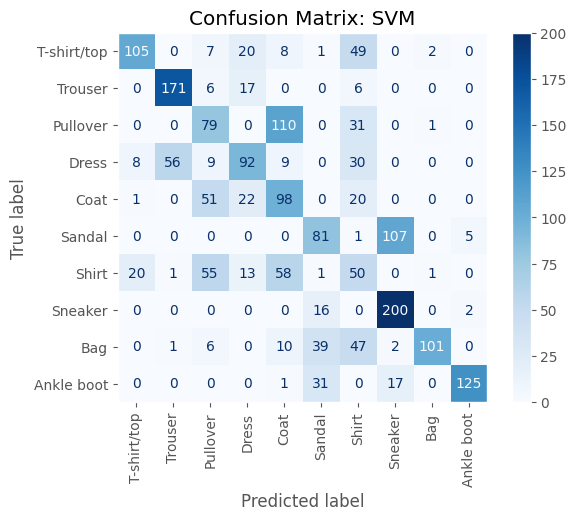

------------------------------------
Accuracy of NN : 0.551
F1 Score of NN : 0.556
Precision of NN : 0.595
Recall of NN : 0.551


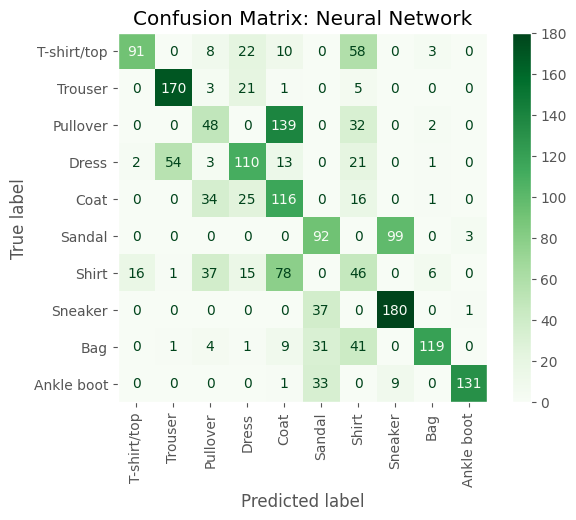

------------------------------------
Accuracy of CNN: 0.552
F1 Score of CNN: 0.559
Precision of CNN: 0.604
Recall of CNN: 0.552
------------------------------------


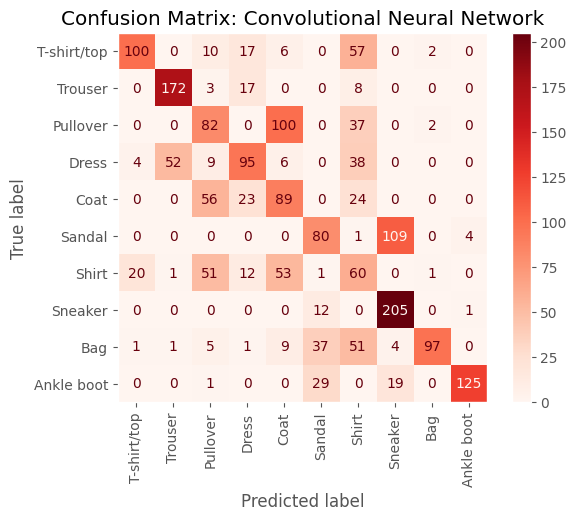

In [ ]:
# SVM Model Evaluation
y_pred = best_svm.predict(test_images_np)
y_pred_mapped = np.array([cluster_to_label[label] for label in y_pred])
svm_accuracy = accuracy_score(test_labels_np, y_pred_mapped)
svm_f1 = f1_score(test_labels_np, y_pred_mapped, average='weighted')
svm_precision = precision_score(test_labels_np, y_pred_mapped, average='weighted')
svm_recall = recall_score(test_labels_np, y_pred_mapped, average='weighted')
print("------------------------------------")
print(f"Accuracy of SVM classifier: {svm_accuracy:.3f}")
print(f"F1 Score of SVM classifier: {svm_f1:.3f}")
print(f"Precision of SVM classifier: {svm_precision:.3f}")
print(f"Recall of SVM classifier: {svm_recall:.3f}")

# Confusion Matrix for SVM
svm_cm = confusion_matrix(test_labels_np, y_pred_mapped)
ConfusionMatrixDisplay(svm_cm, display_labels=categories).plot(cmap="Blues", xticks_rotation='vertical')
plt.grid(False)
plt.title("Confusion Matrix: SVM")
plt.show()

# Neural Network Model Evaluation
with torch.no_grad():
    test_images = test_images.to(device)  
    outputs_1 = model_nn(test_images)
    _, predicted_1 = torch.max(outputs_1, 1)
    predicted_1 = predicted_1.cpu().numpy()  
    predicted_1_mapped = np.array([cluster_to_label[label] for label in predicted_1])
    accuracy_1 = accuracy_score(test_labels_np, predicted_1_mapped)
    f1_1 = f1_score(test_labels_np, predicted_1_mapped, average='weighted')
    precision_1 = precision_score(test_labels_np, predicted_1_mapped, average='weighted')
    recall_1 = recall_score(test_labels_np, predicted_1_mapped, average='weighted')
    print("------------------------------------")
    print(f"Accuracy of NN : {accuracy_1:.3f}")
    print(f"F1 Score of NN : {f1_1:.3f}")
    print(f"Precision of NN : {precision_1:.3f}")
    print(f"Recall of NN : {recall_1:.3f}")

# Confusion Matrix for NN
nn_cm = confusion_matrix(test_labels_np, predicted_1_mapped)
ConfusionMatrixDisplay(nn_cm, display_labels=categories).plot(cmap="Greens", xticks_rotation='vertical')
plt.title("Confusion Matrix: Neural Network")
plt.grid(False)
plt.show()


# CNN Model Evaluation
with torch.no_grad():
    test_tensor_cnn = test_images_cnn.to(device)  
    outputs_cnn = model_cnn(test_tensor_cnn)
    _, predicted_cnn = torch.max(outputs_cnn, 1)
    predicted_cnn = predicted_cnn.cpu().numpy()  
    predicted_cnn_mapped = np.array([cluster_to_label[label] for label in predicted_cnn])
    accuracy_cnn = accuracy_score(test_labels_np, predicted_cnn_mapped)
    f1_cnn = f1_score(test_labels_np, predicted_cnn_mapped, average='weighted')
    precision_cnn = precision_score(test_labels_np, predicted_cnn_mapped, average='weighted')
    recall_cnn = recall_score(test_labels_np, predicted_cnn_mapped, average='weighted')
    print("------------------------------------")
    print(f"Accuracy of CNN: {accuracy_cnn:.3f}")
    print(f"F1 Score of CNN: {f1_cnn:.3f}")
    print(f"Precision of CNN: {precision_cnn:.3f}")
    print(f"Recall of CNN: {recall_cnn:.3f}")
    print("------------------------------------")

# Confusion Matrix for CNN
cnn_cm = confusion_matrix(test_labels_np, predicted_cnn_mapped)
ConfusionMatrixDisplay(cnn_cm, display_labels=categories).plot(cmap="Reds", xticks_rotation='vertical')
plt.title("Confusion Matrix: Convolutional Neural Network")
plt.grid(False)
plt.show()


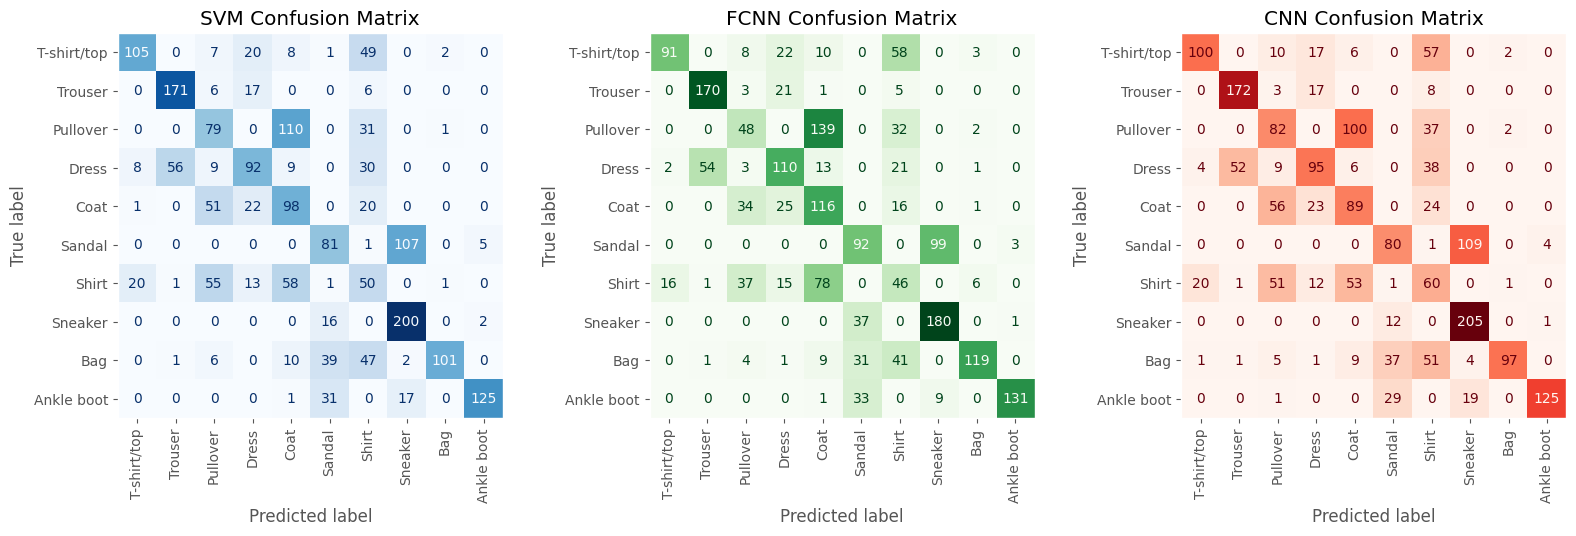

In [ ]:

fig = plt.figure(figsize=(19, 5))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1], wspace=0.3)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

# SVM Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=svm_cm, display_labels=categories).plot(ax=ax1, cmap="Blues", xticks_rotation='vertical',colorbar=False)
ax1.set_title('SVM Confusion Matrix')
ax1.grid(False)

# FCNN Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=nn_cm, display_labels=categories).plot(ax=ax2, cmap="Greens", xticks_rotation='vertical',colorbar=False)
ax2.set_title('FCNN Confusion Matrix')
ax2.grid(False)

# CNN Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=cnn_cm, display_labels=categories).plot(ax=ax3, cmap="Reds", xticks_rotation='vertical',colorbar=False)
ax3.set_title('CNN Confusion Matrix')
ax3.grid(False)


plt.tight_layout()

plt.savefig(f'{output_dir}comp_matr.png', bbox_inches='tight')

plt.show()


### Section 5: A *fully-supervised* approach

Repeat the steps of *Section 3* using the true labels of the dataset. Comment on the results, and draw a comparison between such results and those obtained from the previous *hybrid* pipeline.

In [35]:
best_svm.fit(images_np, labels_np)

# Predict on the test set
y_pred = best_svm.predict(test_images_np)
test_accuracy = accuracy_score(test_labels_np, y_pred)
test_f1 = f1_score(test_labels_np, y_pred, average='weighted')
test_precision = precision_score(test_labels_np, y_pred, average='weighted')
test_recall = recall_score(test_labels_np, y_pred, average='weighted')

print("------------------------------------")

print(f"Test Set Accuracy: {test_accuracy:.4f}")
print(f"Test Set F1 Score: {test_f1:.4f}")
print(f"Test Set Precision: {test_precision:.4f}")
print(f"Test Set Recall: {test_recall:.4f}")

------------------------------------
Test Set Accuracy: 0.8880
Test Set F1 Score: 0.8878
Test Set Precision: 0.8886
Test Set Recall: 0.8880


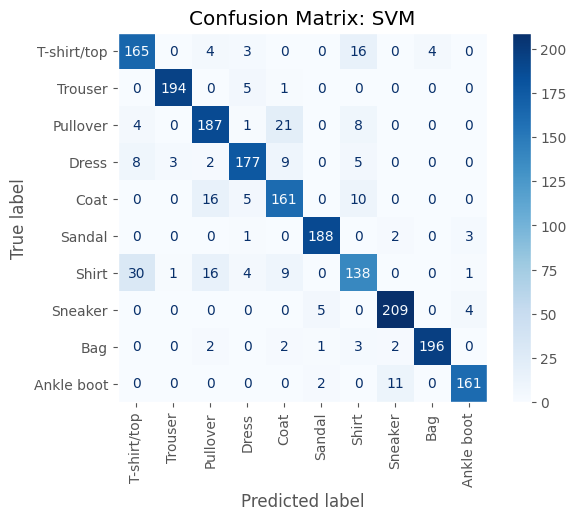

In [36]:
# Confusion Matrix for SVM
svm_cm = confusion_matrix(test_labels_np, y_pred)
ConfusionMatrixDisplay(svm_cm, display_labels=categories).plot(cmap="Blues", xticks_rotation='vertical')
plt.grid(False)
plt.title("Confusion Matrix: SVM")
plt.show()

In [ ]:
epochs = 20

# Define input and output sizes
input_size = X_tensor.shape[1]
output_size = 10

dataset_train = TensorDataset(images, labels)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size_nn, shuffle=True, )

dataset_test = TensorDataset(test_images, test_labels)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size_nn, shuffle=False)

  # Initialize the model, criterion, and optimizer
model = NeuralNetwork(input_size, hidden_size, act_nn, output_size).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr_nn)

        # Training loop
for epoch in range(epochs):
  model.train()
  for inputs, lab in dataloader_train:
    optimizer.zero_grad()
    inputs = inputs.to(device)
    lab = lab.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, lab)
    loss.backward()
    optimizer.step()
  print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")

        # Evaluate the model on the test set
model.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
  for inputs, lab in dataloader_test:
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)
    all_predictions.extend(predictions.cpu().numpy())
    all_labels.extend(lab.cpu().numpy())

accuracy = accuracy_score(all_labels, all_predictions)
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')
print('------------------------------------')
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Epoch [1/20], Loss: 33.6129
Epoch [2/20], Loss: 25.6811
Epoch [3/20], Loss: 20.4017
Epoch [4/20], Loss: 2.1449
Epoch [5/20], Loss: 4.5758
Epoch [6/20], Loss: 0.9757
Epoch [7/20], Loss: 2.7324
Epoch [8/20], Loss: 3.8058
Epoch [9/20], Loss: 2.5134
Epoch [10/20], Loss: 1.4563
Epoch [11/20], Loss: 0.8765
Epoch [12/20], Loss: 3.6358
Epoch [13/20], Loss: 0.2880
Epoch [14/20], Loss: 5.9276
Epoch [15/20], Loss: 2.0623
Epoch [16/20], Loss: 0.9552
Epoch [17/20], Loss: 0.0558
Epoch [18/20], Loss: 0.0916
Epoch [19/20], Loss: 0.4891
Epoch [20/20], Loss: 0.3595
------------------------------------
Accuracy: 0.8415
Precision: 0.8457
Recall: 0.8415
F1 Score: 0.8430


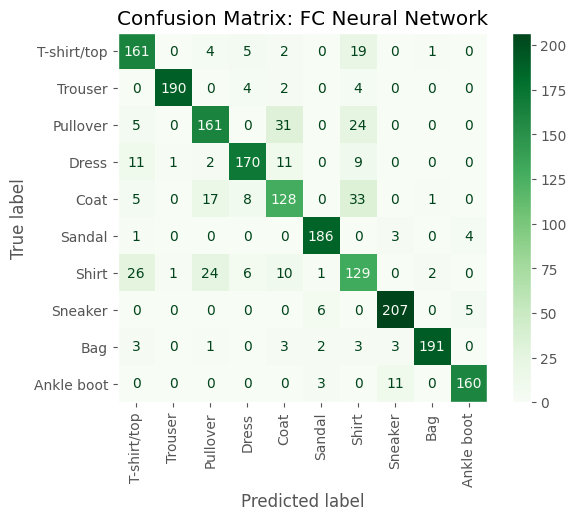

In [38]:
# Confusion Matrix for NN
nn_cm = confusion_matrix(all_labels, all_predictions)
ConfusionMatrixDisplay(nn_cm, display_labels=categories).plot(cmap="Greens", xticks_rotation='vertical')
plt.title("Confusion Matrix: FC Neural Network")
plt.grid(False)
plt.show()


In [39]:
# Initialize the model with the best hyperparameters
output_size = 10

dataset_train = TensorDataset(X_tensor_cnn, labels)
dataloader_train = DataLoader(dataset_train, batch_size=batch_size_cnn, shuffle=True, )

dataset_test = TensorDataset(test_images_cnn, test_labels)
dataloader_test = DataLoader(dataset_test, batch_size=batch_size_cnn, shuffle=False)

model_cnn = CNN(conv1_out_channels, conv2_out_channels, fc1_neurons, act, output_size).to(device)  # Use ReLU or the best activation you found

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_cnn.parameters(), lr=lr_cnn)

# Training loop
epochs = 20
for epoch in range(epochs):
    model_cnn.train()
    train_loss = 0
    for inputs, lab in dataloader_train:
        inputs = inputs.to(device)
        lab = lab.to(device)
        optimizer.zero_grad()
        outputs = model_cnn(inputs)
        loss = criterion(outputs, lab)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_loss /= len(dataloader_train)
    print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}")

# Evaluate the model on the test set
model_cnn.eval()
all_predictions = []
all_labels = []
with torch.no_grad():
    for inputs, lab in dataloader_test:
        inputs = inputs.to(device)
        outputs = model_cnn(inputs)
        _, predictions = torch.max(outputs, 1)
        all_predictions.extend(predictions.cpu().numpy())
        all_labels.extend(lab.cpu().numpy())

print("------------------------------------")

# Compute accuracy on the test set
test_accuracy = accuracy_score(all_labels, all_predictions)
test_f1 = f1_score(all_labels, all_predictions, average='weighted')
test_precision = precision_score(all_labels, all_predictions, average='weighted')
test_recall = recall_score(all_labels, all_predictions, average='weighted')
print(f"Test Set Accuracy: {test_accuracy:.4f}")
print(f"Test Set F1 Score: {test_f1:.4f}")
print(f"Test Set Precision: {test_precision:.4f}")
print(f"Test Set Recall: {test_recall:.4f}")



Epoch [1/20], Train Loss: 0.8304
Epoch [2/20], Train Loss: 0.5000
Epoch [3/20], Train Loss: 0.4240
Epoch [4/20], Train Loss: 0.3700
Epoch [5/20], Train Loss: 0.3391
Epoch [6/20], Train Loss: 0.3079
Epoch [7/20], Train Loss: 0.2783
Epoch [8/20], Train Loss: 0.2496
Epoch [9/20], Train Loss: 0.2282
Epoch [10/20], Train Loss: 0.2029
Epoch [11/20], Train Loss: 0.1882
Epoch [12/20], Train Loss: 0.1682
Epoch [13/20], Train Loss: 0.1497
Epoch [14/20], Train Loss: 0.1396
Epoch [15/20], Train Loss: 0.1195
Epoch [16/20], Train Loss: 0.1066
Epoch [17/20], Train Loss: 0.0925
Epoch [18/20], Train Loss: 0.0835
Epoch [19/20], Train Loss: 0.0704
Epoch [20/20], Train Loss: 0.0587
------------------------------------
Test Set Accuracy: 0.9020
Test Set F1 Score: 0.9014
Test Set Precision: 0.9029
Test Set Recall: 0.9020


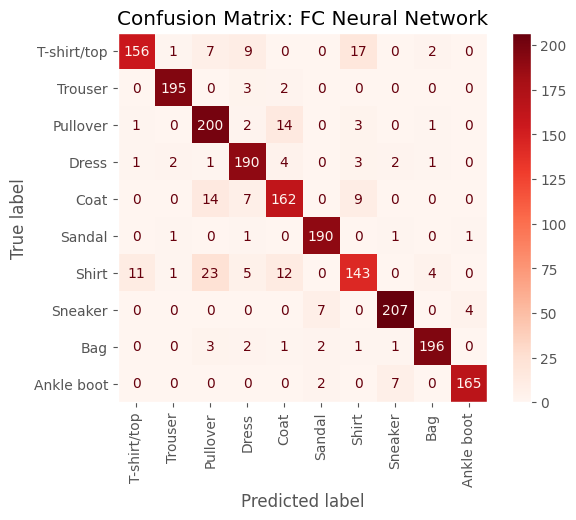

In [40]:
# Confusion Matrix for NN
cnn_cm = confusion_matrix(all_labels, all_predictions)
ConfusionMatrixDisplay(cnn_cm, display_labels=categories).plot(cmap="Reds", xticks_rotation='vertical')
plt.title("Confusion Matrix: FC Neural Network")
plt.grid(False)
plt.show()

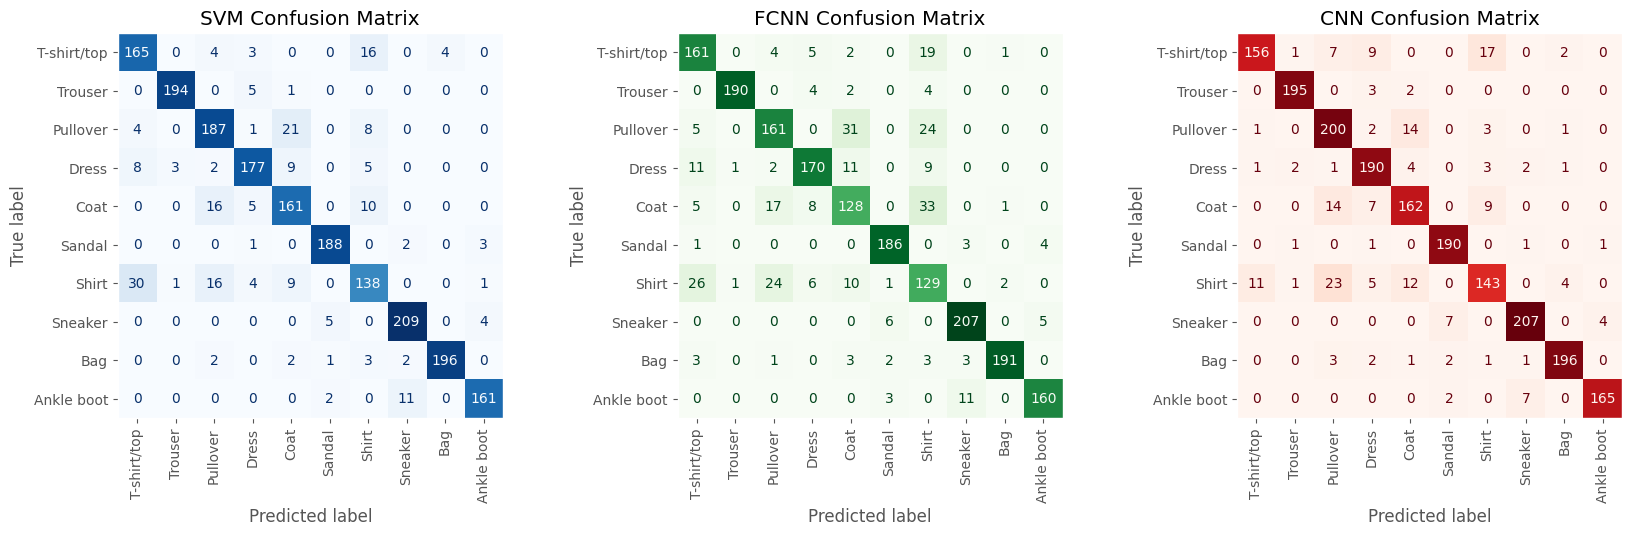

In [ ]:
fig = plt.figure(figsize=(20, 5))
gs = fig.add_gridspec(1, 3, width_ratios=[1, 1, 1], wspace=0.3)

ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
ax3 = fig.add_subplot(gs[2])

# SVM Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=svm_cm, display_labels=categories).plot(ax=ax1, cmap="Blues", xticks_rotation='vertical',colorbar=False)
ax1.set_title('SVM Confusion Matrix')
ax1.grid(False)

# FCNN Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=nn_cm, display_labels=categories).plot(ax=ax2, cmap="Greens", xticks_rotation='vertical',colorbar=False)
ax2.set_title('FCNN Confusion Matrix')
ax2.grid(False)

# CNN Confusion Matrix
ConfusionMatrixDisplay(confusion_matrix=cnn_cm, display_labels=categories).plot(ax=ax3, cmap="Reds", xticks_rotation='vertical',colorbar=False)
ax3.set_title('CNN Confusion Matrix')
ax3.grid(False)

plt.tight_layout()

plt.savefig(f'{output_dir}conf_matr_sup.png', bbox_inches='tight')

plt.show()
